In [ ]:
import numpy as np
import scipy.sparse as sparse
import numba

In [2]:
@numba.jit(nopython=True)
def divmod(i,n):
    d = i//n
    m = i - d*n
    return d,m

@numba.jit(nopython=True)
def _NZTensorElement(a, b, c, d, S, A1, A2):
    n = A1.shape[0]
    r = A1[a,c] * np.conj(A2[b,d]) * S[b,c] + np.conj(A1[b,d]) * A2[a,c] * S[d,a]
    if b == d:
        for i in range(n):
            r -= A1[a,i] * A2[i,c] * S[d,i]
    if a == c:
        for i in range(n):
            r -= np.conj(A1[b,i]) * np.conj(A2[i,d]) * S[i,c]
    return r

@numba.jit(nopython=True)
def NZTensorElements(S, A1, A2, cutoff=1e-15):
    n = A1.shape[0]
    n2 = n*n
    R = []
    for I in range(n2):
        a, b = divmod(I, n) # np.divmod(I, n)
        for J in range(n2):
            c, d = divmod(J, n) # np.divmod(J, n)
            r = _NZTensorElement(a, b, c, d, S, A1, A2)
            if np.abs(r) > cutoff:
                R.append((I, J, r))
    return R

In [3]:
def NZTensorSparse(S, A1, A2): #why don't you use Numba here?
    R = np.array(NZTensorElements(S, A1, A2),
                 dtype=[('i', 'i'), ('j', 'i'), ('v', 'D')]) #need explanation for these lines
    i, j, v = R["i"], R["j"], R["v"]
    d = A1.shape[0]
    d2 = d*d
    return sparse.coo_matrix((v,(i,j)), shape=(d2,d2))

In [4]:
# \int_0^\infty d\tau\; g(\tau) e^{i\omega\tau} assuming g(\tau) = exp(-\tau/\tau_c)
def specDenseExp(tauc, omega):
    return 1 / (1/tauc - 1j*omega) #this is on the last page of the scan Daniel sent me

In [5]:
def diffMat(x, f1=lambda x: x, f2=lambda x: x): #don't understand lambda x: x ?
    return f1(x[:,None]) - f2(x[None,:]) # delta[i,j] = f1(x[i]) - f2(x[j])

In [6]:
import numpy as np
from scipy import linalg
from scipy import sparse
import qutip as qt

opstr2fun = {'x': lambda dim: qt.spin_Jx((dim-1)/2),
             'y': lambda dim: qt.spin_Jy((dim-1)/2),
             'z': lambda dim: qt.spin_Jz((dim-1)/2),
             'p': lambda dim: qt.spin_Jp((dim-1)/2),
             'm': lambda dim: qt.spin_Jm((dim-1)/2),
             'i': qt.identity}
def mkSpinOp(dims, specs):
    ops = [qt.identity(d) for d in dims]
    for ind, opstr in specs:
        ops[ind] = ops[ind] * opstr2fun[opstr](dims[ind])
    return qt.tensor(ops)
def idOp(dims):
    return mkSpinOp(dims, []) #what exactly is specs, and why is it empty here?
def zeroOp(dims):# what's this actually supposed to do?
    d = np.prod(dims)
    return qt.Qobj(sparse.csr_matrix((d, d), dtype=np.float64), 
                       dims=[list(dims)]*2, type="oper", isherm=True) 
def mkH1(dims, ind, parvec):
    axes = ['x', 'y', 'z']
    components = [v * mkSpinOp(dims, [(ind,ax)]) for v, ax in zip(parvec, axes) if v!=0]
    if components:
        return sum(components)
    else:
        return zeroOp(dims)
def mkH12(dims, ind1, ind2, parmat):
    axes = ['x', 'y', 'z']
    components = []
    for i in range(3):
        for j in range(3):
            if parmat[i,j] != 0:
                components.append(parmat[i,j] * mkSpinOp(dims, [(ind1,axes[i]), (ind2,axes[j])]))
    if components:
        return sum(components)
    else:
        return zeroOp(dims)

In [7]:
def point_dipole_dipole_coupling(r):

    # H = - \frac{ \mu_0 }{ 4 \pi } \frac{ \gamma_j \gamma_k \hbar^2}{ r_{jk}^3 }
    #       \left( 3 (\bold{I}_j \cdot \bold{e}_{jk})  (\bold{I}_k \cdot \bold{e}_{jk}) - \bold{I}_j \cdot \bold{I}_k \right)

    dr3 = -4*np.pi*1e-7 * (2.0023193043617 * 9.27400968e-24)**2 / (4*np.pi*1e-30)/6.62606957e-34/1e6 # MHz * A^3

    if np.isscalar(r):
        # assume r is aligned with z
        d = dr3 / r**3
        A = np.diag([-d, -d, 2*d])
    else:
        norm_r = np.linalg.norm(r)
        d = dr3 / norm_r**3
        e = r / norm_r
        A = d * (3 * e[:,np.newaxis] * e[np.newaxis,:] - np.eye(3))

    return A

In [8]:
mT2angfreq = 2.00231930436153*9.27400968e-24 / (6.62606957e-34/2/np.pi)/1e9 # rad/us / mT
b0 = mT2angfreq * 0.05 # mT  -> rad/us
I = 1
A = np.diag([-2.6, -2.6, 49.2]) * 2*np.pi # Mrad/s
kS = 100. # 1/us
kT = 1.  # 1/us
ree = [10, 0, 0] # A ; ree for r electron electron

# EED
# d = -max(eig(Dmat)) = -max([-d,-d,2 d]) < 0
# D = 3/2 d < 0
Dee = point_dipole_dipole_coupling(ree) * 2*np.pi # Mrad/s
d = -np.max(np.linalg.eigh(Dee)[0]) #this will give the largest eigenvalue of all the eigenvalues of whatever the above box is

print("ree : ", np.linalg.norm(ree), " A")
print("DEE : ", np.linalg.eigh(Dee)[0]/(2*np.pi), " MHz")
print("B0  : ", b0/2/np.pi, " MHz")

ree :  10.0  A
DEE :  [-104.0820321    52.04101605   52.04101605]  MHz
B0  :  1.4012476336782334  MHz


In [9]:
def singletYield_noRelaxation(Heff, rho0, KS):
    Q = -rho0.data.toarray()
    x = linalg.solve_continuous_lyapunov(-1j*Heff.data.toarray(), Q)
    return 2 * np.trace(x @ KS.data).real

In [10]:

dims = [2, 2, 2*I+1]
Hhfc = mkH12(dims, 0, 2, A)
Heed = mkH12(dims, 0, 1, Dee)
Ps = 1/4 * mkSpinOp(dims,[]) - mkH12(dims, 0, 1, np.identity(3))
one = mkSpinOp(dims,[])
Pt = one - Ps
rho0 = Pt / Pt.tr()
KS = kS/2 * Ps
K = kT/2 * Pt + KS
Heff0 = Hhfc + Heed - 1j * K #K is transfer to singlet or triplet states

oris = [np.array([0, 0, 1]), np.array([1, 0, 0])]
yields0 = []
for ori in oris:
    b0vec = ori * b0
    Hzee = mkH1(dims, 0, b0vec) + mkH1(dims, 1, b0vec)
    Heff = Heff0 + Hzee
    yields0.append(singletYield_noRelaxation(Heff, rho0, KS))    
yields0

[0.2699566093507181, 0.35284387248724713]

In [11]:
def singletYield_NZRelaxation(Heff, rho0, KS, H1s, X2tauc, tauc):
    dim = Heff.shape[0]
    dim2 = dim*dim
    omega, V = np.linalg.eig(Heff.data.toarray())
    domega = diffMat(omega, f1=np.conj)
    invV = np.linalg.inv(V)
    sigma0 = invV @ rho0.data.toarray() @ invV.conj().T
    Aeb = [invV @ A.data.toarray() @ V for A in H1s] 
    RSop = np.zeros((dim2,dim2), dtype=np.complex128)
    for i in range(len(H1s)):
        S = specDenseExp(taucs[i], domega)
        RSop += X2taucs[i]/taucs[i] * NZTensorSparse(S, Aeb[i], Aeb[i])
    A = sparse.diags(1j * domega.conj().reshape(-1, order='C')) - RSop
    x = linalg.solve(A, sigma0.reshape(-1, order='C'))
    rhoS = V @ x.reshape((dim,dim)) @ V.conj().T
    return 2 * np.trace(rhoS @ KS.data).real

In [12]:
H1s = [Heed / d]
taucs = [0.001] # us
X2taucs = [1] # 1/us

yieldsR = []
for ori in oris: #z and x
    b0vec = ori * b0
    Hzee = mkH1(dims, 0, b0vec) + mkH1(dims, 1, b0vec)
    Heff = Heff0 + Hzee
    yieldsR.append(singletYield_NZRelaxation(Heff, rho0, KS, H1s, X2taucs, taucs))    
yieldsR

[0.270520396517486, 0.3617341295654977]

In [13]:
Hex0 = -(1/2*mkSpinOp(dims, []) + mkH12(dims, 0, 1, 2*np.identity(3))) # in multiples of jex
H1s = [Hex0]
taucs = [0.001] # us
X2taucs = [1] # 1/us

yieldsR = []
for ori in oris:
    b0vec = ori * b0
    Hzee = mkH1(dims, 0, b0vec) + mkH1(dims, 1, b0vec)
    Heff = Heff0 + Hzee
    yieldsR.append(singletYield_NZRelaxation(Heff, rho0, KS, H1s, X2taucs, taucs))    
yieldsR

[0.2732305560933067, 0.35821155776328506]

In [14]:
#This is calculating the yield for when we include 
H1s = [mkSpinOp(dims, [(0,ax)]) for ax in ("x", "y", "z")] + [mkSpinOp(dims, [(1,ax)]) for ax in ("x", "y", "z")]
taucs = [0.001]*6 # us
X2taucs = [1]*6 # 1/us

yieldsR = []
for ori in oris:
    b0vec = ori * b0
    Hzee = mkH1(dims, 0, b0vec) + mkH1(dims, 1, b0vec)
    Heff = Heff0 + Hzee
    yieldsR.append(singletYield_NZRelaxation(Heff, rho0, KS, H1s, X2taucs, taucs))    
yieldsR

[0.6564258342397535, 0.6731327609548741]

In [15]:
# TODO

# Check code!

# Assumptions:
# Measure of compass sensitivity: difference of yields for field in x and z direction
# If not stated otherwise assume that ree is pointing along x

# Consider 2 scenarios: A) kS = kT = 1/us 
#                       B) kS >> kT; kT = 1/us

# Plot compass sensitivity vs. d for d in [0, -2000*2*pi] rad/us for both scenarios assuming no spin relaxation

# For a dipolar coupling constant corresponding to ree = 4 A and 10 a and 16 A, plot the compass sensitivity vs. kS for fixed kT

# For scenario A and auspicious parameters for scenario B, investigate the effect of spin relaxation assuming that relaxation is induced by 
# a) modulation of the EED coupling
# b) modulation of the exchange coupling
# c) random field relaxation
# vary the relaxation rate (X2taucs) and the correlation time (tauc)



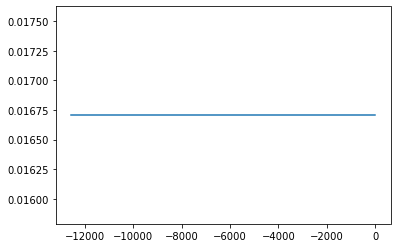

In [16]:
import matplotlib.pyplot as plt
#copying last code to start my tasks, first attempt
ds = -np.linspace(0,2000*2*np.pi, 10) #rad/us
H1s = [mkSpinOp(dims, [(0,ax)]) for ax in ("x", "y", "z")] + [mkSpinOp(dims, [(1,ax)]) for ax in ("x", "y", "z")]
taucs = [0.001]*6 # us
X2taucs = [1]*6 # 1/us

yieldsR = []
sensitivities = []
for d in ds:
    
    for ori in oris:
        b0vec = ori * b0
        Hzee = mkH1(dims, 0, b0vec) + mkH1(dims, 1, b0vec)
        Heff = Heff0 + Hzee
        yieldsR.append(singletYield_NZRelaxation(Heff, rho0, KS, H1s, X2taucs, taucs))
    sensitivity = np.max(yieldsR) - np.min(yieldsR)
    sensitivities.append(sensitivity)
plt.plot(ds, sensitivities)



In [32]:
ds

array([ 653.96669483, -326.98334741, -326.98334741])